In [1]:
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown


In [2]:
# Define the ticker and date range
ticker = "BBNI.JK"
start_date = "2014-01-01"
end_date = "2024-11-13"

# Fetch data
data_csv = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to make the date a regular column, not the index
data_csv = data_csv.reset_index()

# Display the first few rows to confirm
print(data_csv.tail())

# Optionally, save the data to a CSV file
data_csv.to_csv("BBRI_JK.csv", index=False)

data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

# Print the monthly data
print(obs)
print(data)

[*********************100%***********************]  1 of 1 completed
           Date    Open    High     Low   Close  Adj Close    Volume
2683 2024-11-06  5425.0  5425.0  5100.0  5125.0     5125.0  67214100
2684 2024-11-07  5150.0  5175.0  5025.0  5025.0     5025.0  63745800
2685 2024-11-08  5075.0  5125.0  4970.0  4980.0     4980.0  51133100
2686 2024-11-11  4950.0  5025.0  4800.0  4990.0     4990.0  44028300
2687 2024-11-12  4960.0  5000.0  4870.0  4930.0     4930.0  70220900
        Open    High     Low   Close
0     1975.0  2000.0  1962.5  1975.0
1     1950.0  1950.0  1912.5  1925.0
2     1925.0  1925.0  1830.0  1840.0
3     1840.0  1857.5  1835.0  1837.5
4     1837.5  1872.5  1837.5  1862.5
...      ...     ...     ...     ...
2548  5250.0  5275.0  5175.0  5225.0
2549  5250.0  5350.0  5150.0  5350.0
2550  5375.0  5425.0  5250.0  5250.0
2551  5300.0  5350.0  5200.0  5300.0
2552  5300.0  5325.0  5225.0  5300.0

[2553 rows x 4 columns]
        Open    High     Low   Close
0     1975.

In [3]:

T = 120
AIC, BIC, HQC, CAIC = [], [], [], []

for n in range(2, 7):
    a, b, c, d = [], [], [], []
    first_time = True

    for i in range(0, T):
        
        if first_time:
            model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

            # Normalize startprob_ to ensure it sums to 1
            model.startprob_ = model.startprob_ / np.sum(model.startprob_)

            # Ensure transition matrix rows sum to 1
            model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

            # If any row sums to 0, reinitialize it to uniform probabilities
            for row in range(n):
                if np.sum(model.transmat_[row]) == 0:
                    model.transmat_[row] = np.full(n, 1 / n)

        # Fit the model using the data
        model.fit(obs[i:i+T])

        log_likelihoods = model.score(obs[i:i+T])
        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)


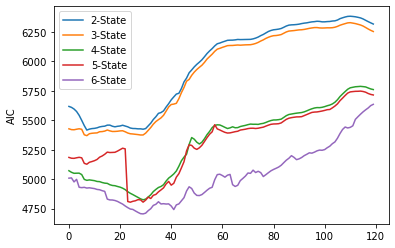

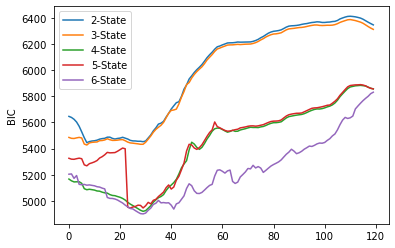

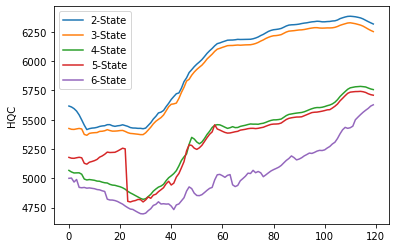

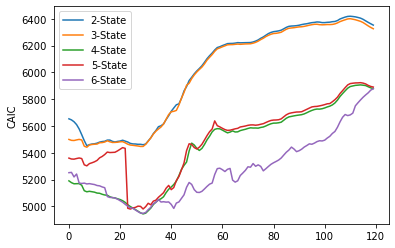

In [4]:

# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")
plt.legend()
plt.savefig(f"{ticker}_AIC_plot.png")  # Save the AIC plot with the ticker in the filename
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.savefig(f"{ticker}_BIC_plot.png")  # Save the BIC plot with the ticker in the filename
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.savefig(f"{ticker}_HQC_plot.png")  # Save the HQC plot with the ticker in the filename
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.savefig(f"{ticker}_CAIC_plot.png")  # Save the CAIC plot with the ticker in the filename
plt.show()


In [6]:
#KEPAKE
obs = data.iloc[:num_rows]
first_time = True
n=5
T = 120
w = int(len(obs)*0.858/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [4]:
num_test=int(0.05*len(data))
# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -2911.1983580209103 is -2911.511897146275 at index 1407.
 iteration 1The closest likelihood value to -2902.1760928922595 is -2901.6493872432043 at index 466.
 iteration 2The closest likelihood value to -2895.3697457094777 is -2897.2433506819593 at index 235.
 iteration 3The closest likelihood value to -2891.583508113714 is -2892.5969908350207 at index 160.
 iteration 4The closest likelihood value to -2891.041481520945 is -2892.5969908350207 at index 160.
 iteration 5The closest likelihood value to -2890.719493540267 is -2892.5969908350207 at index 160.
 iteration 6The closest likelihood value to -2888.508508173746 is -2888.287290534833 at index 749.
 iteration 7The closest likelihood value to -2888.410793295849 is -2888.287290534833 at index 749.
 iteration 8The closest likelihood value to -2889.0662439571984 is -2888.287290534833 at index 749.
 iteration 9The closest likelihood value to -2890.0846640424675 is -2888.287290534833 at index 749.

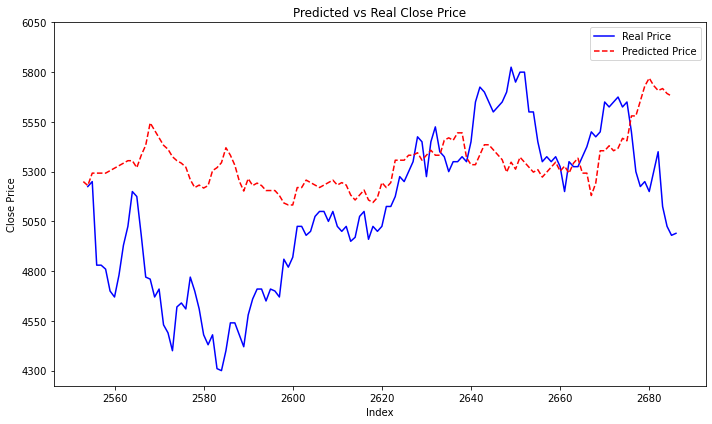

In [5]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))
plt.savefig(f"{ticker}_Prediction_plot.png")
# Show plot
plt.tight_layout()
plt.show()


In [6]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Percentage Error (MAPE): 7.127%


In [7]:
predicted_price

2553    5250.0
2554    5230.0
2555    5292.5
2556    5292.5
2557    5292.5
         ...  
2681    5732.5
2682    5707.5
2683    5717.5
2684    5692.5
2685    5680.0
Name: Close, Length: 133, dtype: float64

In [8]:
real_price

2554    5225.0
2555    5250.0
2556    4830.0
2557    4830.0
2558    4810.0
         ...  
2682    5400.0
2683    5125.0
2684    5025.0
2685    4980.0
2686    4990.0
Name: Close, Length: 133, dtype: float64

In [25]:
#Out of Sample

obs=data
for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3407.0396862648963 is -3407.270512448785 at index 2552.
 iteration 1The closest likelihood value to -3401.5944131238643 is -3402.152539261406 at index 1167.
 iteration 2The closest likelihood value to -3396.2005579311754 is -3396.300260081168 at index 2427.
 iteration 3The closest likelihood value to -3392.283998830449 is -3392.3634001005275 at index 1965.
 iteration 4The closest likelihood value to -3389.835615243473 is -3389.8820776116213 at index 1642.
 iteration 5The closest likelihood value to -3386.512424855519 is -3386.591835098699 at index 1176.
 iteration 6The closest likelihood value to -3384.4119931147043 is -3384.3002383909 at index 1659.
 iteration 7The closest likelihood value to -3382.741541668731 is -3382.765017648209 at index 1987.
 iteration 8The closest likelihood value to -3379.4502386717636 is -3379.367001547755 at index 1912.
 iteration 9The closest likelihood value to -3375.103399628654 is -3375.0736408895577 at index 

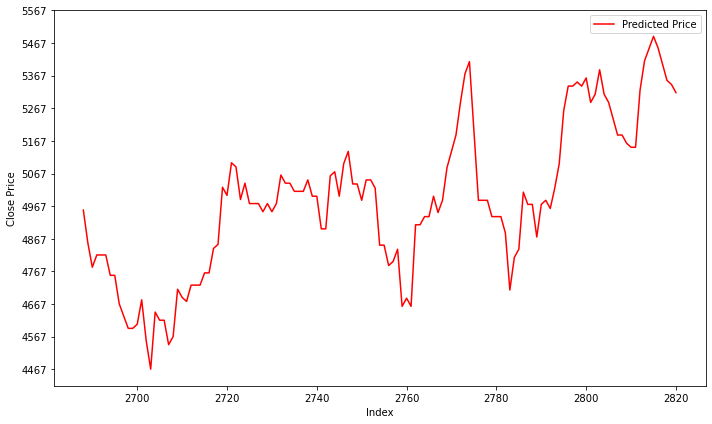

In [29]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]


# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(predicted_price.min()), int(predicted_price.max()) + 100, 100))
plt.savefig(f"{ticker}_Prediction_Out.png")

# Show plot
plt.tight_layout()
plt.show()
